The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


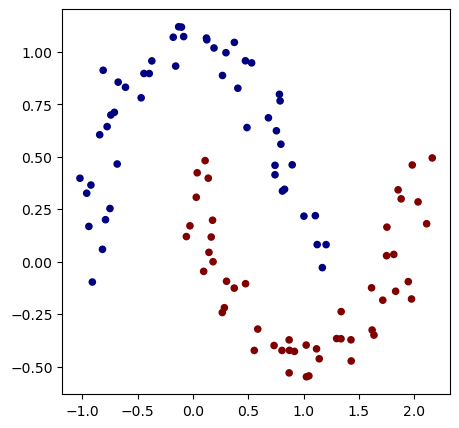

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
import random
from shrimpgrad import Tensor, nn, dtypes

np.random.seed(1337)
random.seed(1337)

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)
X = X.astype(float)
y = y.astype(float)
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [12]:
X_train = Tensor.fromlist(X.shape, X.flatten().tolist())
y_train = Tensor.fromlist((100,1), y.flatten().tolist())
class ShallowNet:
    def __init__(self):
        self.layers: List[Callable[[Tensor], Tensor]] = [
         nn.Linear(2, 50), Tensor.relu,
         nn.Linear(50, 1), Tensor.sigmoid,
        ]
    def __call__(self, x: Tensor):
        return x.sequential(self.layers)

In [13]:
snet = ShallowNet()
sgd = nn.optim.SGD(nn.get_parameters(snet), lr=3.0)

def optimize(model, opt, X, y, epochs=50, lr=0.01):
    target = (y > 0).realize().data()
    for epoch in range(epochs):
        opt.zero_grad()
        out = model(X)
        loss = out.binary_cross_entropy(y)
        loss.realize()
        numerator = (target == (out.data() > 0.5)).sum()
        accuracy = (numerator / out.size(0)) * 100.0
        print(f'epoch={epoch} loss={loss.data()} acc={accuracy}')
        loss.backward()
        opt.step()
optimize(snet, sgd, X_train, y_train)

epoch=0 loss=0.6924601793289185 acc=50.0
epoch=1 loss=0.48582732677459717 acc=82.0
epoch=2 loss=0.5429271459579468 acc=73.0
epoch=3 loss=0.951677680015564 acc=69.0
epoch=4 loss=0.627959668636322 acc=74.0
epoch=5 loss=0.3514842987060547 acc=83.0
epoch=6 loss=0.3155319094657898 acc=84.0
epoch=7 loss=0.3030029535293579 acc=85.0
epoch=8 loss=0.29127824306488037 acc=87.0
epoch=9 loss=0.28193116188049316 acc=88.0
epoch=10 loss=0.27336543798446655 acc=88.0
epoch=11 loss=0.2662883698940277 acc=88.0
epoch=12 loss=0.25974026322364807 acc=88.0
epoch=13 loss=0.2539592981338501 acc=89.0
epoch=14 loss=0.24854768812656403 acc=89.0
epoch=15 loss=0.24338847398757935 acc=90.0
epoch=16 loss=0.23787933588027954 acc=90.0
epoch=17 loss=0.23266573250293732 acc=91.0
epoch=18 loss=0.2276868224143982 acc=90.0
epoch=19 loss=0.2234736979007721 acc=91.0
epoch=20 loss=0.21904687583446503 acc=92.0
epoch=21 loss=0.21722352504730225 acc=91.0
epoch=22 loss=0.21627406775951385 acc=91.0
epoch=23 loss=0.22371932864189148 

(-1.548639298268643, 1.951360701731357)

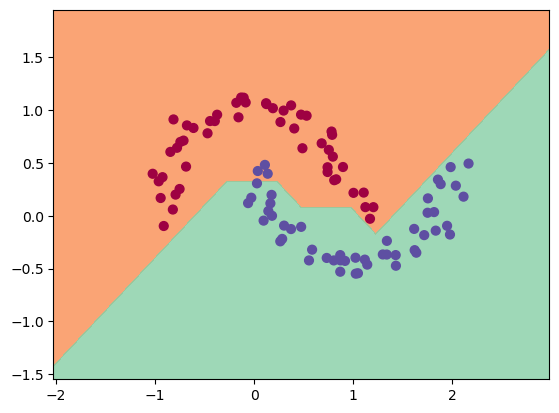

In [14]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
input_ = Tensor.fromlist(Xmesh.shape, data=Xmesh.flatten().tolist())
scores = snet(input_)
scores.realize()
Z = np.array([s > 0.5 for s in scores.data()])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
